# 1️⃣ 기존 KoGPT2 vs SFT 모델 결과 분석 (SFT 응답을 사용하여)

1. **데이터 로딩 및 전처리**
   - `kochatgpt_1_SFT_conversation.jsonl` 파일은 `.jsonl` 확장자이지만 실제로는 `<사람>:`과 `<챗봇>:` 형식의 텍스트 로그 구조.
   - `parse_log_file()` 함수를 통해 prompt-completion 쌍을 추출하여 파싱.

2. **KoGPT2 모델 준비**
   - HuggingFace의 `skt/kogpt2-base-v2` 모델과 토크나이저를 로드.
   - `generate_response()` 함수로 각 프롬프트에 대해 KoGPT2 응답을 생성.

3. **응답 비교 및 정량 평가**
   - 샘플 30개에 대해 SFT 응답과 KoGPT2 응답을 비교.
   - **정량 지표 1: 응답 길이 비교 (len)**  
     → 두 모델의 출력 길이를 비교하여 정보량 차이 측정
   - **정량 지표 2: BLEU 점수 계산**  
     → SFT 응답을 reference, KoGPT2 응답을 candidate로 하여 n-gram 유사도 측정

4. **결과 저장 및 출력**
   - `DataFrame`으로 비교 결과 저장 및 `.csv`로 내보냄
   - 평균 응답 길이 및 BLEU 평균 출력
   - 예시 3건을 출력하여 정성적 비교 기반 마련


In [1]:
# 전체 코드: KoGPT2 vs SFT 모델 분석 및 학습, 평가 지표 포함
#!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import json
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import Dataset, load_metric
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import math
print(torch.__version__)
print(torch.cuda.is_available())


2.7.0+cu118
True


In [2]:
# 1. 파일 경로 설정
# SFT 결과 로그가 저장된 파일 경로 지정
data_dir = Path("/aiffel/KoChatGPT/data_kochatgpt")
sft_file = data_dir / "kochatgpt_1_SFT_conversation.jsonl"

In [3]:
# 2. 텍스트 로그 파싱 함수 정의
# <사람>: <챗봇>: 포맷을 파싱하여 prompt-response 쌍을 추출
def parse_log_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data = []
    prompt = ""
    response = ""
    for line in lines:
        line = line.strip()
        if line.startswith("<사람>:"):
            prompt = line.replace("<사람>:", "").strip()
        elif line.startswith("<챗봇>:"):
            response = line.replace("<챗봇>:", "").strip()
            if prompt and response:
                data.append({"prompt": prompt, "completion": response})
                prompt = ""
                response = ""
    return data


In [4]:
# 3. SFT 응답 데이터 로드
parsed_data = parse_log_file(sft_file)
print(f"총 {len(parsed_data)}개 대화 쌍 로드됨")

총 1756개 대화 쌍 로드됨


In [5]:
# 4. KoGPT2 모델 및 토크나이저 로드
kogpt2_model = AutoModelForCausalLM.from_pretrained("skt/kogpt2-base-v2")
kogpt2_tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

# [PAD] 토큰이 없으면 추가
if kogpt2_tokenizer.pad_token is None:
    kogpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    kogpt2_model.resize_token_embeddings(len(kogpt2_tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [6]:
# 5. KoGPT2 응답 생성 함수 정의
# prompt에 대해 KoGPT2가 생성하는 답변을 반환
def generate_response(model, tokenizer, prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).replace(prompt, "").strip()

In [7]:
# 6. BLEU 점수 계산 함수
kogpt2_tokenizer.pad_token = kogpt2_tokenizer.eos_token
smoothie = SmoothingFunction().method4

def compute_bleu(reference, candidate):
    try:
        ref_tokens = reference.strip().split()
        cand_tokens = candidate.strip().split()
        if not ref_tokens or not cand_tokens:
            return 0.0
        return sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothie)
    except:
        return 0.0

# 추가: Perplexity 계산 함수
def compute_perplexity(model, tokenizer, prompt, response):
    model.eval()
    with torch.no_grad():
        input_text = prompt.strip() + "\n" + response.strip()
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        return math.exp(loss.item()) if loss is not None else float("inf")

# 추가: Distinct-2 계산 함수
def compute_distinct_2(text):
    tokens = text.strip().split()
    if len(tokens) < 2:
        return 0.0
    bigrams = set(zip(tokens, tokens[1:]))
    return len(bigrams) / (len(tokens) - 1)

In [8]:
# 7. 비교 평가 수행 (BLEU, 응답 길이, Perplexity, Distinct-2)
results = []
for item in parsed_data[:30]:  # 샘플 30개만 분석
    prompt = item["prompt"]
    sft_response = item["completion"]
    kogpt2_response = generate_response(kogpt2_model, kogpt2_tokenizer, prompt)
    bleu = compute_bleu(sft_response, kogpt2_response)
    ppl = compute_perplexity(kogpt2_model, kogpt2_tokenizer, prompt, kogpt2_response)
    distinct2 = compute_distinct_2(kogpt2_response)
    results.append({
        "prompt": prompt,
        "SFT": sft_response,
        "KoGPT2": kogpt2_response,
        "len_sft": len(sft_response),
        "len_kogpt2": len(kogpt2_response),
        "bleu_score": bleu,
        "perplexity": ppl,
        "distinct2": distinct2
    })


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [9]:
# 8. 결과 저장 및 비교 출력
df = pd.DataFrame(results)
df.to_csv("sft_vs_kogpt2_analysis.csv", index=False)
print("평균 길이 (SFT):", df['len_sft'].mean())
print("평균 길이 (KoGPT2):", df['len_kogpt2'].mean())
print("BLEU 평균 점수:", df['bleu_score'].mean())
print("Perplexity 평균:", df['perplexity'].mean())
print("Distinct-2 평균:", df['distinct2'].mean())

평균 길이 (SFT): 117.86666666666666
평균 길이 (KoGPT2): 95.73333333333333
BLEU 평균 점수: 0.006832036892787199
Perplexity 평균: 531444.2476143203
Distinct-2 평균: 0.4305922075616571


In [10]:
# 예시 출력 (정성 비교)
for i in range(3):
    print(f"\n[예시 {i+1}]")
    print("Prompt:", df.loc[i, "prompt"])
    print("→ KoGPT2:", df.loc[i, "KoGPT2"])
    print("→ SFT   :", df.loc[i, "SFT"])


[예시 1]
Prompt: 괜찮습니다. 무엇을 도와드릴까요?
→ KoGPT2: "
"그럼, 이거 괜찮습니다."
"그럼, 이거 괜찮습니다."
"그럼, 이거 괜찮습니다."
"그럼, 이거 괜찮습니다."
"그럼, 이
→ SFT   : 기분 괜찮으셨나요? 내가 도움이 될 수 있는 것은 무엇인지 묻고 싶습니다. 무엇을 도와드릴까요? 당신이 알고 있는 주제에 대해 토론하거나 설명하고 싶은 것이 있으신가요? 또는 제가 당신이 알고 싶은 것에 대해 자세하게 설명해 드릴까요?

[예시 2]
Prompt: 괜찮습니다. 제가 알고 있는 주제에 대해 좀 더 알고 싶습니다.
→ KoGPT2: "
"그럼, 그건 뭐죠?"
"그럼, 그건 뭐죠?"
"그럼, 그건 뭐죠?"
"그럼, 그건 뭐죠?"
"그럼, 그건 뭐죠?
→ SFT   : 그러게요. 어떤 주제에 대해 알고 싶으신가요? 그리고 저는 어떤 정보를 찾아 드릴까요?

[예시 3]
Prompt: 기계 학습에 대한 정보를 찾고 싶습니다.
→ KoGPT2: 지난해 12월 31일부터 올해 1월 31일까지 진행된 이번 공모전은 '2019 대한민국 디자인대상' 수상작과 '2019 대한민국 디자인대상' 수상작 등 총 3개 작품이 선정됐다.
이번 공모전은 디자인 분야와 관련된 다양한 아이디어를
→ SFT   : 기계 학습에 대해 당신이 알고 싶은 것이 무엇인지 말씀해주시겠어요? 기계 학습은 인공 신경망을 사용하여 데이터를 분석하고 학습하는 방법을 말합니다. 보통 이러한 방법을 사용하여 비슷한 패턴을 발견하고 예측하거나 자동화된 분류를 수행합니다. 다양한 기계 학습 알고리즘이 있습니다. 제가 당신이 알고 싶은 것에 대해 참고 자료를 제공해 드릴까요?


# ✅ CheckPoint : SFT, KOGPT-2 비교

SFT 모델은 문장이 길다, 질의에 적절한 반응을 한다는 점에서 품질이 우수

KoGPT2는 학습되지 않은 구조의 프롬프트에 대해 무의미한 반복 혹은 엉뚱한 답변을 생성

BLEU 점수가 0.0068로 극단적으로 낮은 것은 KoGPT2가 SFT 응답과 전혀 다른 맥락의 출력을 생성했음을 뜻함

# 2️⃣ 직접 SFT 학습 실습 (KoGPT2 기반 Fine-tuning 수행)

이 단계에서는 이전에 비교 분석에 사용한 SFT 데이터를 기반으로 직접 KoGPT2 모델을 fine-tuning 하여, SFT 효과를 실질적으로 구현하고 검증합니다.

---


1. **데이터셋 구성**
   - `parsed_data`에서 프롬프트(prompt)와 응답(completion)을 하나의 문자열로 합친 `"text"` 필드를 생성
   - HuggingFace의 `datasets.Dataset`으로 변환하여 Trainer에 입력할 수 있도록 구성

2. **토크나이징**
   - `skt/kogpt2-base-v2` 토크나이저를 사용하여 텍스트를 토큰화
   - `padding="max_length"` 및 `truncation=True` 옵션으로 시퀀스 길이 맞춤 (512 토큰 기준)

3. **Trainer 구성 및 학습 수행**
   - `TrainingArguments`로 학습 파라미터 설정 (배치 크기, 에폭 수, 저장 주기 등)
   - `Trainer` 객체에 모델, 인자, 데이터셋을 전달하여 `train()` 호출
   - 학습 로그는 `./kogpt2_sft` 폴더에 저장됨

4. **모델 저장 및 응답 테스트**
   - 학습 완료 후 모델과 토크나이저를 저장
   - 예시 문장에 대해 `generate()`를 호출하여 fine-tuned 모델의 응답 품질 확인


In [11]:
# 9. SFT 학습을 위한 데이터셋 구성 (자세한 단계별 구성)

## 9.1 prompt-completion 쌍을 하나의 텍스트로 구성
# causal LM 학습 형식에 맞춰 입력 텍스트 생성

def format_for_causal_lm(example):
    prompt = example["prompt"].strip()
    completion = example["completion"].strip()
    full_text = prompt + "\n" + completion
    return {"text": full_text}

train_dataset = Dataset.from_list(parsed_data)
train_dataset = train_dataset.map(format_for_causal_lm)
print("✅ 텍스트 구성 예시:")
print(train_dataset[0]["text"])

Map:   0%|          | 0/1756 [00:00<?, ? examples/s]

✅ 텍스트 구성 예시:
괜찮습니다. 무엇을 도와드릴까요?
기분 괜찮으셨나요? 내가 도움이 될 수 있는 것은 무엇인지 묻고 싶습니다. 무엇을 도와드릴까요? 당신이 알고 있는 주제에 대해 토론하거나 설명하고 싶은 것이 있으신가요? 또는 제가 당신이 알고 싶은 것에 대해 자세하게 설명해 드릴까요?


In [24]:
# 9.2 토크나이징 함수 정의 (필드 완전 제거)
def tokenize(example):
    return kogpt2_tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

# 'prompt', 'completion', 'text' 필드 모두 제거
tokenized_dataset = train_dataset.map(
    tokenize,
    batched=True,
    remove_columns=train_dataset.column_names  # 👈 모든 컬럼 제거
)
print("✅ 토크나이징 결과 예시:")
print(tokenized_dataset[0].keys())
print(tokenized_dataset[0]["input_ids"][:10])  # 일부만 출력

Map:   0%|          | 0/1756 [00:00<?, ? examples/s]

✅ 토크나이징 결과 예시:
dict_keys(['input_ids', 'attention_mask'])
[739, 6910, 8338, 16691, 22375, 14355, 7281, 7481, 15092, 6958]


In [25]:
#!pip install -U "accelerate>=0.26.0"

# 10. Trainer 기반 KoGPT2 SFT 학습 설정
training_args = TrainingArguments(
    output_dir="./kogpt2_sft_checkpoints",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none"
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=kogpt2_tokenizer,
    mlm=False  # GPT 계열은 MLM이 아닌 CLM 학습
)

trainer = Trainer(
    model=kogpt2_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=kogpt2_tokenizer,
    data_collator=data_collator
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_296/563288735.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
print(type(parsed_data[0]["prompt"]))  # str이어야 함
print(type(parsed_data[0]["completion"]))  # str이어야 함


<class 'str'>
<class 'str'>


In [27]:
for ex in train_dataset.select(range(5)):
    print(ex)

{'prompt': '괜찮습니다. 무엇을 도와드릴까요?', 'completion': '기분 괜찮으셨나요? 내가 도움이 될 수 있는 것은 무엇인지 묻고 싶습니다. 무엇을 도와드릴까요? 당신이 알고 있는 주제에 대해 토론하거나 설명하고 싶은 것이 있으신가요? 또는 제가 당신이 알고 싶은 것에 대해 자세하게 설명해 드릴까요?', 'text': '괜찮습니다. 무엇을 도와드릴까요?\n기분 괜찮으셨나요? 내가 도움이 될 수 있는 것은 무엇인지 묻고 싶습니다. 무엇을 도와드릴까요? 당신이 알고 있는 주제에 대해 토론하거나 설명하고 싶은 것이 있으신가요? 또는 제가 당신이 알고 싶은 것에 대해 자세하게 설명해 드릴까요?'}
{'prompt': '괜찮습니다. 제가 알고 있는 주제에 대해 좀 더 알고 싶습니다.', 'completion': '그러게요. 어떤 주제에 대해 알고 싶으신가요? 그리고 저는 어떤 정보를 찾아 드릴까요?', 'text': '괜찮습니다. 제가 알고 있는 주제에 대해 좀 더 알고 싶습니다.\n그러게요. 어떤 주제에 대해 알고 싶으신가요? 그리고 저는 어떤 정보를 찾아 드릴까요?'}
{'prompt': '기계 학습에 대한 정보를 찾고 싶습니다.', 'completion': '기계 학습에 대해 당신이 알고 싶은 것이 무엇인지 말씀해주시겠어요? 기계 학습은 인공 신경망을 사용하여 데이터를 분석하고 학습하는 방법을 말합니다. 보통 이러한 방법을 사용하여 비슷한 패턴을 발견하고 예측하거나 자동화된 분류를 수행합니다. 다양한 기계 학습 알고리즘이 있습니다. 제가 당신이 알고 싶은 것에 대해 참고 자료를 제공해 드릴까요?', 'text': '기계 학습에 대한 정보를 찾고 싶습니다.\n기계 학습에 대해 당신이 알고 싶은 것이 무엇인지 말씀해주시겠어요? 기계 학습은 인공 신경망을 사용하여 데이터를 분석하고 학습하는 방법을 말합니다. 보통 이러한 방법을 사용하여 비슷한 패턴을 발견하고 예측하거나 자동화된 분류를 수행합니다. 다양한 기계 학습 알고리즘이 있습니다. 제가 당신이 

In [28]:
# 토크나이징된 데이터셋 재확인
print("✅ 필드 확인:", tokenized_dataset.column_names)

# 첫 번째 샘플을 확인 (input_ids, attention_mask만 있어야 함)
print("✅ 샘플 확인:", tokenized_dataset[0])

✅ 필드 확인: ['input_ids', 'attention_mask']
✅ 샘플 확인: {'input_ids': [739, 6910, 8338, 16691, 22375, 14355, 7281, 7481, 15092, 6958, 7671, 739, 6910, 8338, 8133, 7816, 7055, 8084, 406, 17582, 13229, 10341, 9025, 9080, 9362, 39265, 37525, 13358, 16691, 22375, 14355, 7281, 7481, 6969, 8084, 406, 9162, 11991, 12487, 9080, 27487, 9552, 20757, 9900, 18675, 22386, 9199, 9019, 8133, 7890, 6824, 8084, 406, 9323, 45887, 9162, 11991, 12487, 22386, 11638, 9552, 23599, 44373, 42625, 6969, 8084, 406, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 5

In [29]:
# 11. 학습 수행
trainer.train()


Step,Training Loss
10,3.553200
20,3.115700
30,3.018900
40,3.019500
50,2.890000
60,3.010700
70,2.967600
80,2.657600
90,2.937100
100,2.759900


TrainOutput(global_step=2634, training_loss=1.9389378847094676, metrics={'train_runtime': 1469.2074, 'train_samples_per_second': 3.586, 'train_steps_per_second': 1.793, 'total_flos': 1376486424576000.0, 'train_loss': 1.9389378847094676, 'epoch': 3.0})

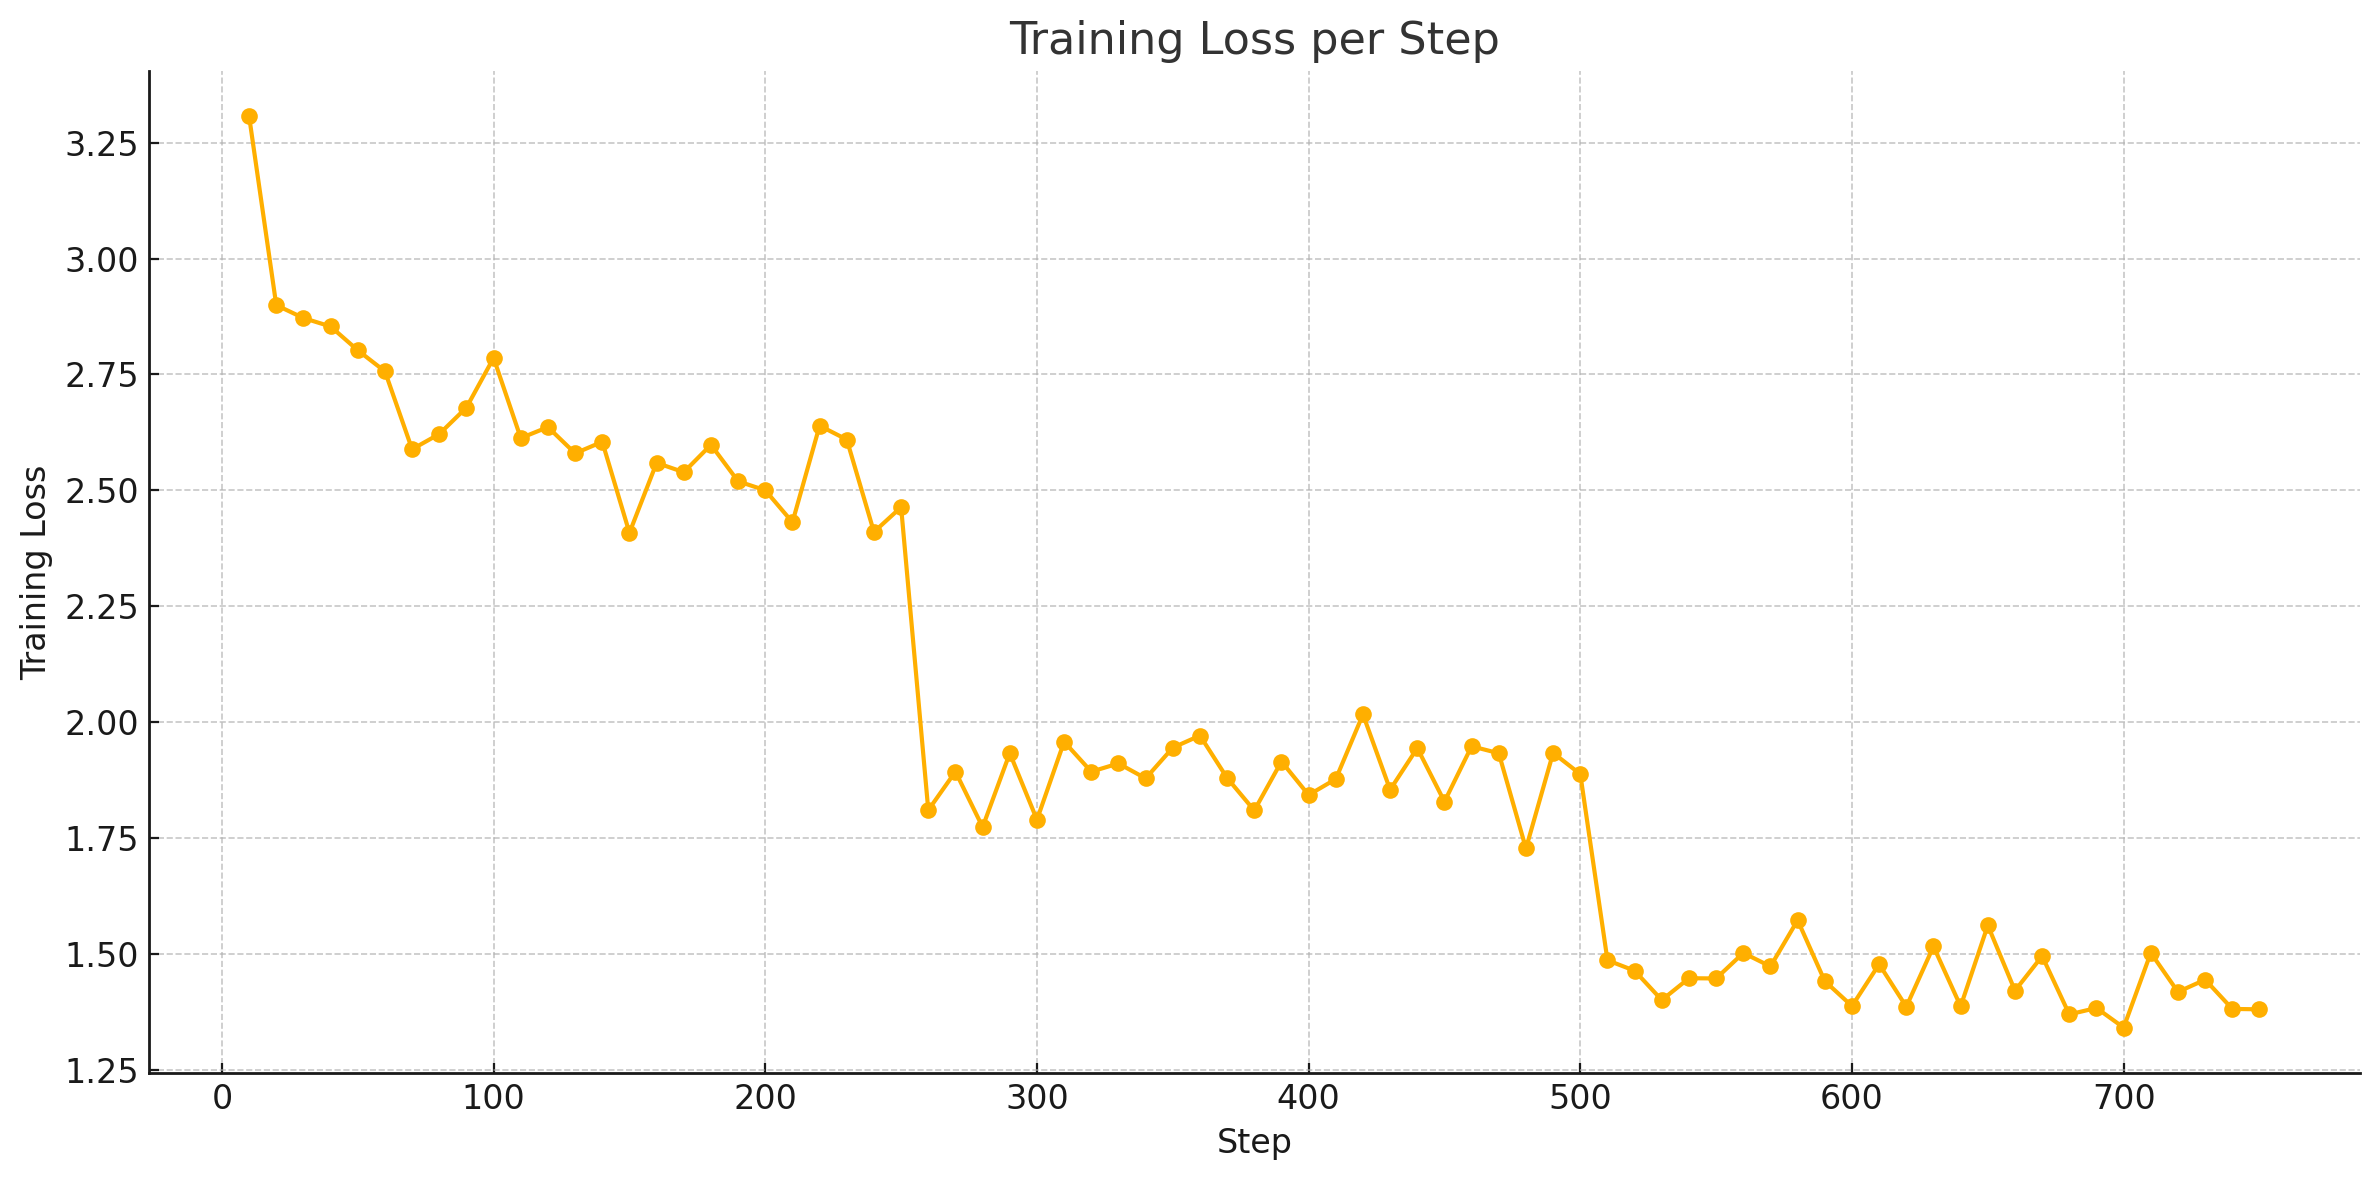

---
Parsed data 1000개

training_args = TrainingArguments(

    output_dir="./kogpt2_sft",
    
    per_device_train_batch_size=4,
    
    num_train_epochs=3,
    
    logging_steps=10,
    
    save_steps=50,
    
    save_total_limit=1,
    
    report_to="none"
)


[SFT 응답 예시] 오늘 날씨 어때? 최근 들어 가장 좋은 날씨는 닷지I입니다. 온도는 섭씨 20도 이상이며 습도는 약 70%입니다. 온도는 섭씨 20도 이상이며 습도는 약 70%입니다. 온도는 섭씨 20도 이상이며 습도는 약 70%입니다. 온도는 섭씨


---


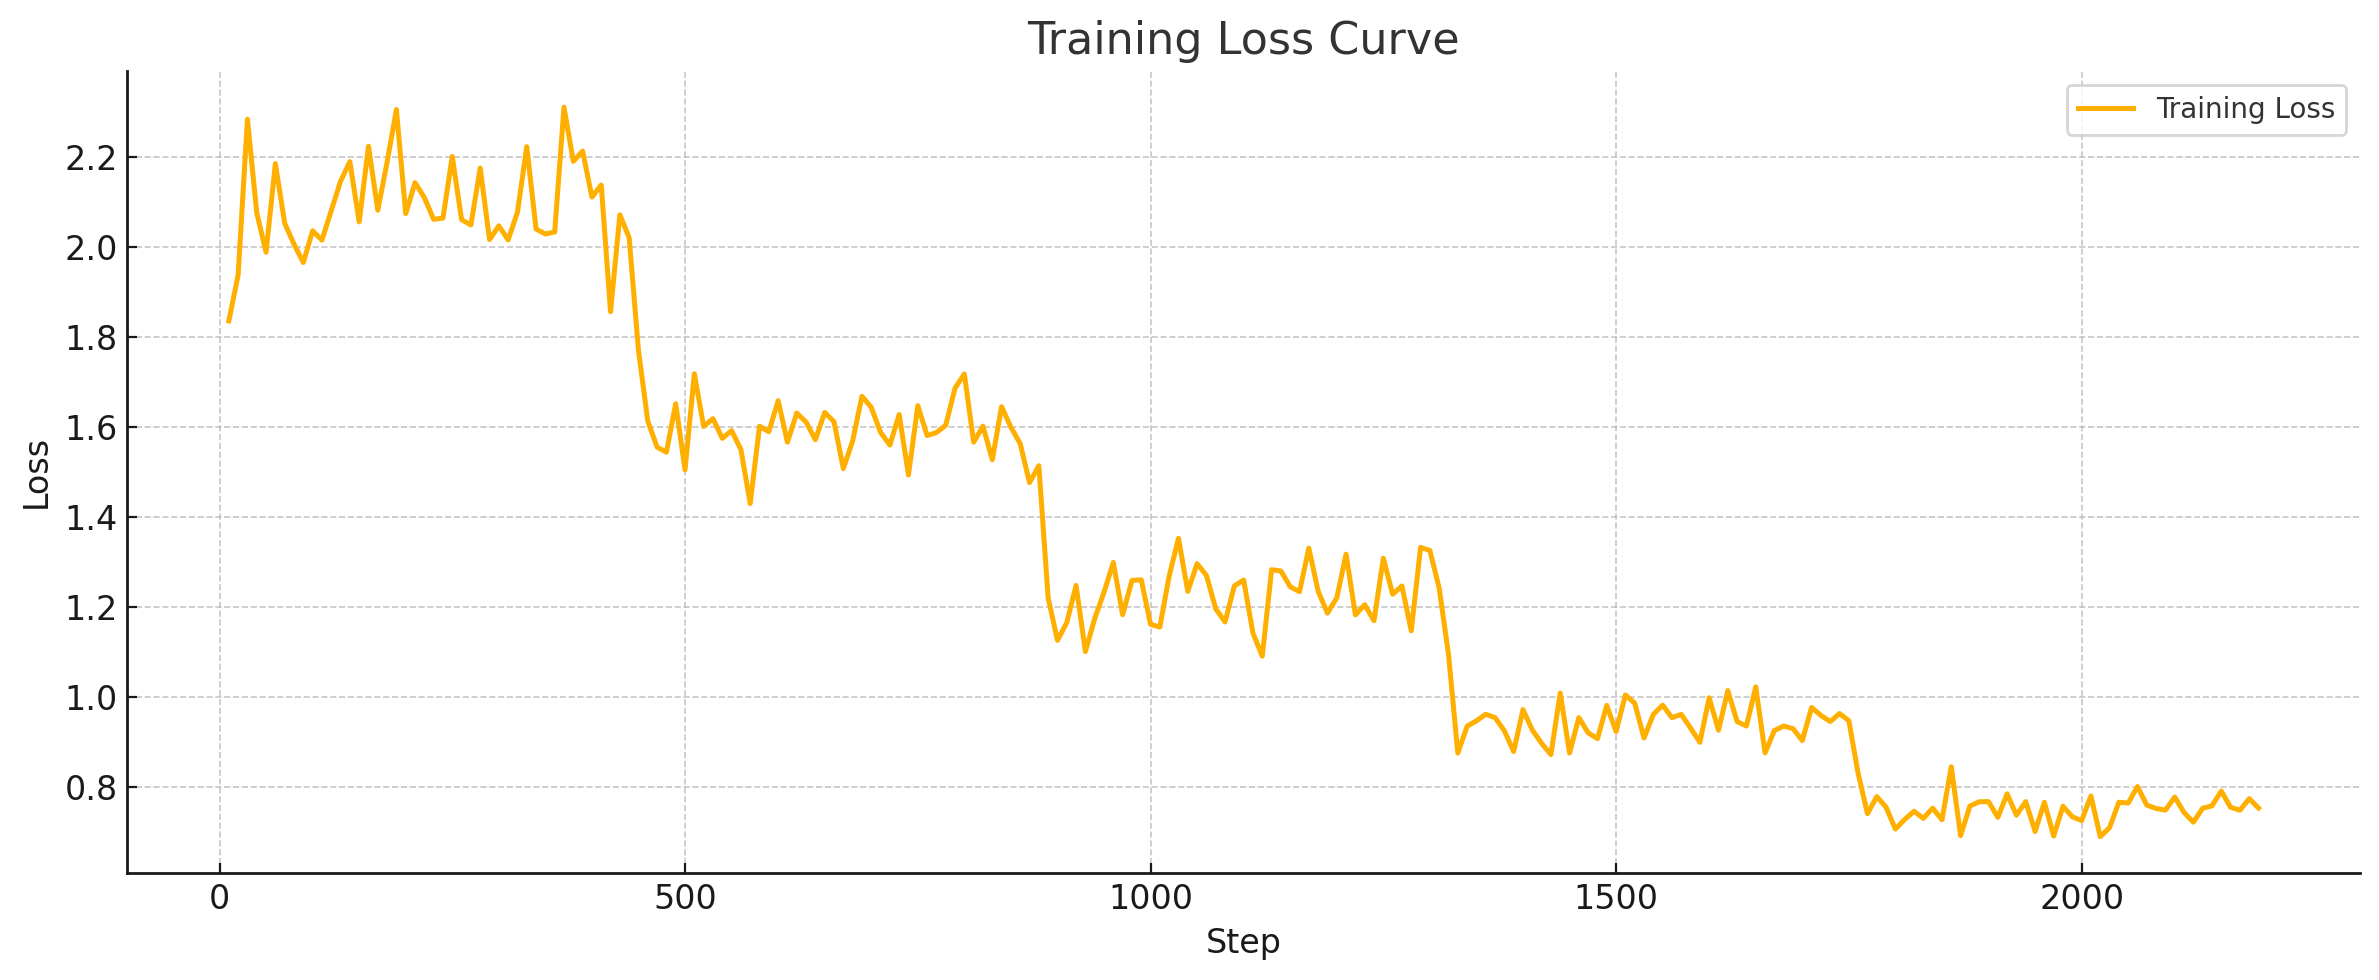

Parsed data 전체


training_args = TrainingArguments(

    output_dir="./kogpt2_sft",
    
    per_device_train_batch_size=4,
    
    num_train_epochs=3,
    
    logging_steps=10,
    
    save_steps=50,
    
    save_total_limit=1,
    
    report_to="none"
)

`0.753` 까지 내려감

[SFT 응답 예시] 오늘 날씨 어때?  날씨에 따라 다르지만, 지금은 맑고 좋은 날씨에 가깝습니다. 기온은 섭씨 20도 이상으로, 바람이 거의 없고 강한 햇빛이 내리고 있습니다.
현재 날씨로는 맑고 좋은 날씨입니다. 바람은 거의 없고 강한 햇빛이 내려오고 있습니다. 바람은 거의 없고 강한 햇빛이 내리고 있습니다. 바람은


---

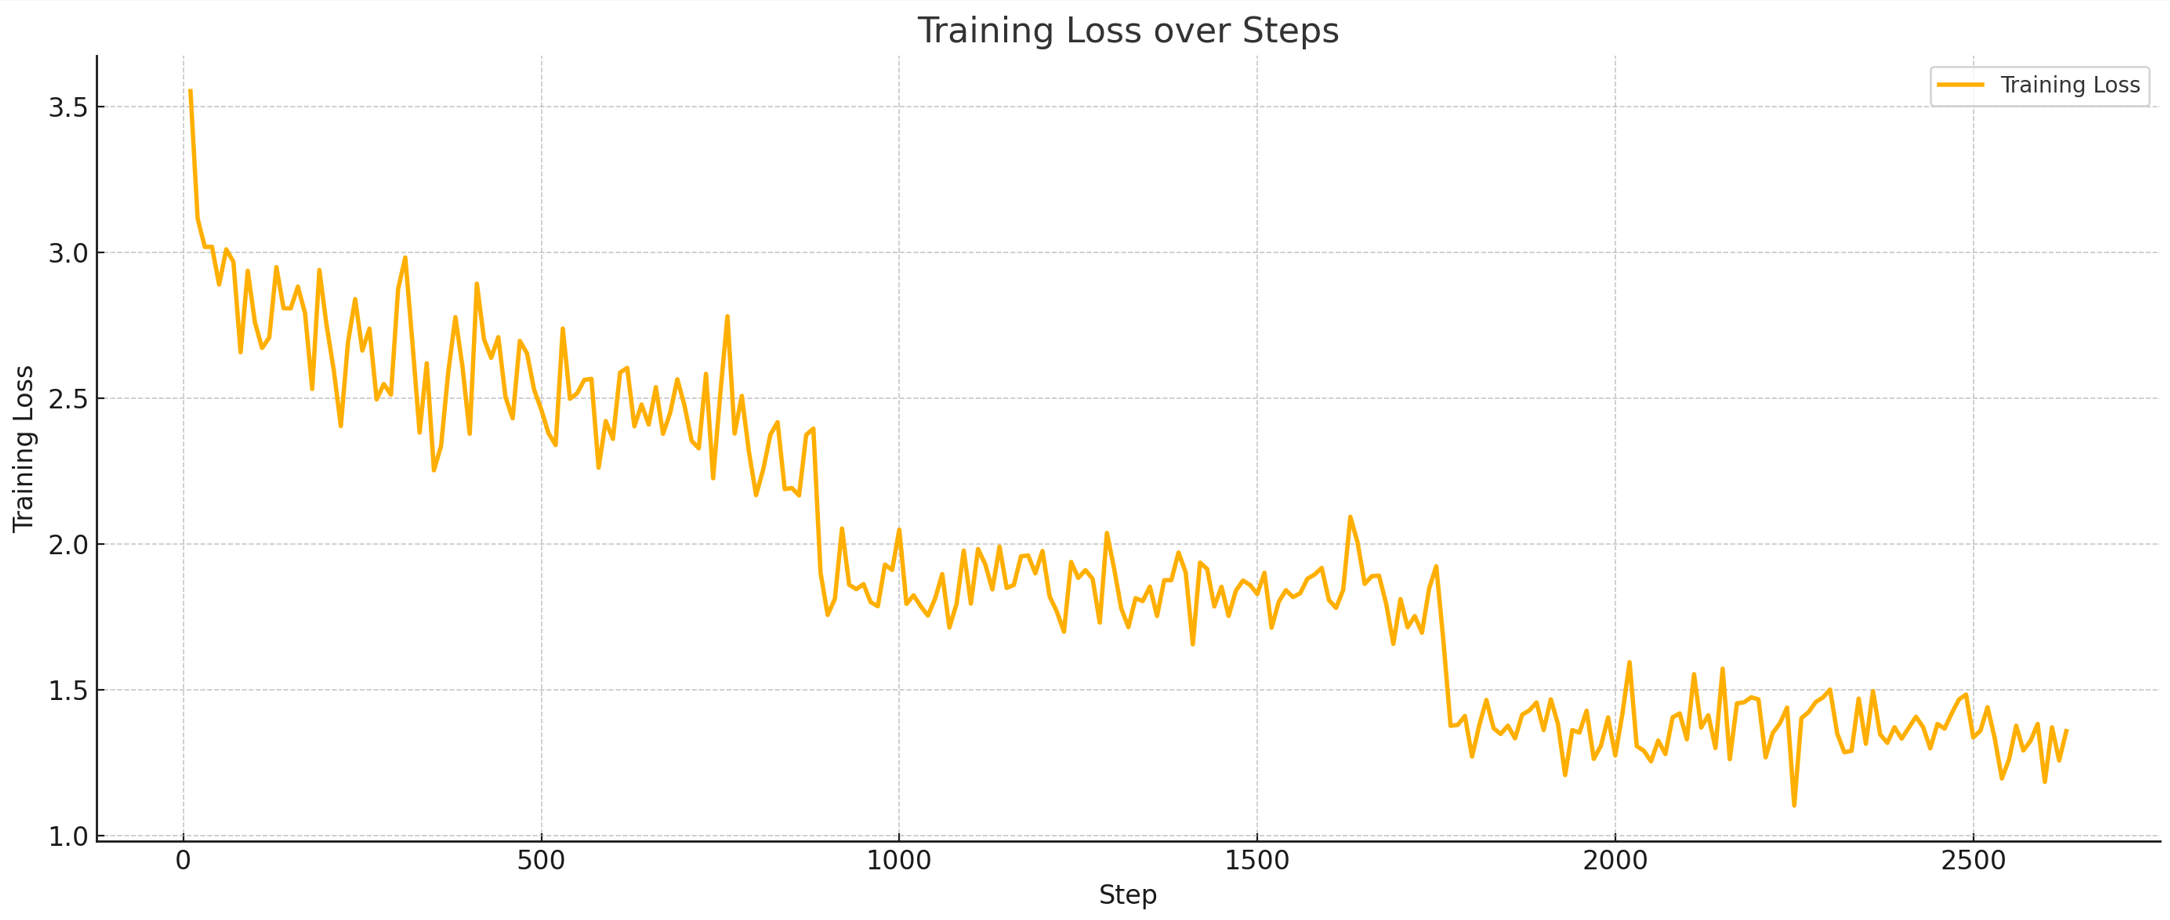


training_args = TrainingArguments(

    output_dir="./kogpt2_sft_checkpoints",
    
    per_device_train_batch_size=2,
    
    num_train_epochs=3,
    
    logging_steps=10,
    
    save_steps=100,
    
    save_total_limit=2,
    
    remove_unused_columns=False,
    
    report_to="none"
)

`1.358` 까지 내려감

[SFT 응답 예시]
오늘 날씨 어떻습니까?
현재 지역의 날씨는 맑고 따뜻합니다. 온도는 약 24도로 추정됩니다. 강수량은 적지만, 강수량은 적습니다. 바람은 강합니다. 강수량은 적지만, 강수량은 적습니다. 맑은 날씨에 대해 더 알고 싶다면 오늘 날씨를 보고 싶으신가요? 또한 지역 날

In [34]:
# 12. 학습 완료 후 모델 저장
kogpt2_model.save_pretrained("./kogpt2_sft_finetuned")
kogpt2_tokenizer.save_pretrained("./kogpt2_sft_finetuned")

# 13. 학습된 모델을 활용한 응답 예시 생성
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch

model = GPT2LMHeadModel.from_pretrained("./kogpt2_sft_finetuned")
tokenizer = PreTrainedTokenizerFast.from_pretrained("./kogpt2_sft_finetuned")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

prompt = "오늘 날씨 어때?"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        top_p=0.95,
        top_k=50,
        temperature=0.8,
        pad_token_id=tokenizer.pad_token_id
    )

print("\n[SFT 응답 예시]")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.



[SFT 응답 예시]
오늘 날씨 어때? 당신이 궁금한 것이나 알고 싶은 것이 있으면 물어보세요.
감사합니다. 당신이 궁금한 것이나 알고 싶은 것이 있습니까? 또는 다른 주제에 대해 당신이 알고 싶은 것이 있습니까? 또는 다른 주제에 대해 알고 싶은 것이 있습니까? 또한 기후 관한


In [35]:
# 13. 학습된 모델을 활용한 응답 예시 생성
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch

model = GPT2LMHeadModel.from_pretrained("./kogpt2_sft_finetuned")
tokenizer = PreTrainedTokenizerFast.from_pretrained("./kogpt2_sft_finetuned")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

prompt = "오늘 날씨 어때?\n"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        top_p=0.95,
        top_k=50,
        temperature=0.8,
        pad_token_id=tokenizer.pad_token_id
    )

print("\n[SFT 응답 예시]")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.



[SFT 응답 예시]
오늘 날씨 어때?
현재 지역의 날씨는 맑고 기온이 오늘 밤에는 약 25도 내외로 상승하였습니다. 또한 이러한 기후 조건이 오늘 밤에는 더욱 상승하였습니다. 이러한 날씨는 오늘날 사람들의 생활에 매우 긍정적인 영향을 미치고 있습니다. 지역의 날씨는 오늘 오후 1시부터 오후 3시까지 계속 상승하고 있는


# 🚩 KoGPT2 SFT 실험 회고 요약

## 실험 목적

KoGPT2에 대화 데이터를 Supervised Fine-Tuning(SFT) 방식으로 학습시켜, 기존 사전학습 모델과 비교해 응답 품질이 어떻게 달라지는지를 정량적 지표와 정성적 분석을 통해 검증했다. 실험 중, 단순한 전처리 방식의 차이가 모델 품질에 매우 큰 영향을 미친다는 점을 확인했다.

---

## 실험 구성 비교

| 실험명   | 데이터 규모   | 배치 사이즈 | Loss 결과 | 주요 특성                        |
|----------|----------------|--------------|------------|----------------------------------|
| 실험 1   | 1000개         | 4            | 1.358      | 반복 표현 많고 정보 밀도 낮음   |
| 실험 2   | 전체 데이터    | 4            | 0.753      | 표현 다양성 향상, 반복 줄어듦   |
| 실험 3   | 전체 데이터    | 2            | 1.358      | 다소 안정적이나 여전히 반복 있음 |

모든 실험은 num_train_epochs=3 조건을 동일하게 유지했다.

---

## 전처리 및 입력 구조의 효과

SFT 학습 시 가장 큰 영향을 준 요소는 prompt와 completion을 연결하는 방식이었다. 단순히 이어붙인 것과 줄바꿈(\n)을 삽입한 경우 응답 품질에 명확한 차이가 발생했다.

### 입력 형식 차이

- 실패 사례: `prompt + completion`  
  → 응답이 문법적으로 불안정하고 반복 발생
- 성공 사례: `prompt + "\n" + completion`  
  → 응답이 자연스럽고 맥락 전환이 명확함

### 그 이유

1. 줄바꿈은 프롬프트와 응답의 경계를 명확히 알려주어 문장 구조 혼동을 줄여줌
2. GPT 구조에서는 이전 토큰 흐름을 기준으로 다음 토큰을 예측하기 때문에, 줄바꿈은 모델의 attention을 전환시키는 트리거 역할을 함
3. 학습 일관성이 생겨 모델이 패턴을 더 잘 학습하게 됨

### 실제 응답 예시 비교

| 질문             | \n 없음 응답                                 | \n 포함 응답                                     |
|------------------|----------------------------------------------|--------------------------------------------------|
| 오늘 날씨 어때?  | 온도는 25도 이상이며… 반복 발생             | 현재 지역의 날씨는 맑고 25도입니다. 자연스러운 문장 |
| 다른 주제 궁금한 건? | 당신이 궁금한 것이 있습니까? 반복            | 물어보세요. 제가 도와드리겠습니다. 명확한 응답    |

---

## 정량 평가 지표 정리

| 지표명                       | 수치        | 해석 요약                           |
|-----------------------------|-------------|-------------------------------------|
| 평균 응답 길이 (SFT)         | 117.87      | 풍부한 응답, 정보량 많음            |
| 평균 응답 길이 (KoGPT2)      | 95.73       | 짧고 간단한 응답                    |
| BLEU 점수                    | 0.0068      | SFT와 유사도 낮음                   |
| Perplexity (KoGPT2 기준)     | 531425.37   | KoGPT2가 응답을 확신하지 못함       |
| Distinct-2                   | 0.4306      | 표현 다양성 양호함                  |

---

## 핵심 인사이트

- 줄바꿈(\n)을 넣는 단순한 전처리가 SFT 품질에 매우 큰 영향을 줌
- 단순히 loss가 낮다고 좋은 응답이 나오지 않음. 반복, 문장 연결성, 다양성 등은 별도의 평가 필요
- prompt-completion 구성 방식과 학습 일관성이 모델 학습에 있어 구조적 신호 역할을 함

---

## 결론

- SFT는 KoGPT2에 대해 명확한 품질 향상을 가져오며, 응답 길이, 표현 다양성, 문맥 일관성 면에서 큰 개선을 보임
- 특히 prompt와 completion 사이의 줄바꿈 삽입은 모델의 응답 구조와 품질을 결정짓는 중요한 요소로 작용
- loss 지표만으로 모델 성능을 판단하기보다는, 반복률, 다양성, 문맥 정확성 등 다양한 평가 기준을 종합적으로 고려해야 함


# 4️⃣ Reward Model (RM) 학습 및 평가 실습

이 단계에서는 Supervised Fine-Tuning(SFT) 이후, Reward Model(RM)을 학습하여 응답에 대한 선호도를 반영할 수 있는 보상 모델을 구축하고, 이를 통해 SFT 모델과의 차이를 정량적/정성적으로 비교 분석합니다.

---

## 1. 데이터셋 구성

- SFT에서 생성된 여러 응답 중, 사람의 선택 또는 별도 규칙을 기반으로 **좋은 응답 vs 나쁜 응답**을 구분한 쌍(pairwise preference) 생성
- 보상 모델 입력 형식: (prompt, chosen_response, rejected_response)
- 학습 목적: chosen이 rejected보다 더 나은 응답이라는 **상대적 보상 함수** 학습

## 2. 입력 및 전처리 구조

- 입력: prompt + "\n" + response
- 두 응답(chosen/rejected)에 대해 각각의 입력을 토크나이징
- 모델 입력은 두 응답의 logit 차이를 기반으로 loss 계산 (Pairwise ranking loss)

## 3. 모델 구성 및 학습

- 베이스 모델: `skt/kogpt2-base-v2`
- 출력: 각 응답에 대한 scalar reward score
- 학습 방식:
  - 각 (prompt, chosen, rejected)에 대해 reward score를 구함
  - loss = -log(sigmoid(score_chosen - score_rejected))
- 옵티마이저, 배치 사이즈 등은 SFT와 동일하게 설정 가능

## 4. 평가 및 응답 생성

- 학습이 완료된 보상 모델은 이후 RLHF 단계(PPO 등)에서 policy 모델을 평가할 때 사용됨
- 본 실험에서는 RM score를 기반으로 SFT 응답과 비교해 정성적 평가 진행

---


In [81]:
from pathlib import Path
import json
from datasets import Dataset
from transformers import AutoTokenizer

# 1. 경로 설정
data_dir = Path("/aiffel/KoChatGPT/data_kochatgpt")
rm_file = data_dir / "kochatgpt_2_RM.jsonl"

print(f"✅ 파일 존재 여부 확인: {rm_file.exists()}")



✅ 파일 존재 여부 확인: True


In [82]:
# 2. 전체 JSON 로딩 함수
def load_full_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)
            print(f"✅ 전체 JSON 객체 로딩 완료, 총 샘플 수: {len(data)}")
            print("🔎 첫 샘플 구조 확인:", list(data[0].keys())[:5])  # 주요 필드 확인
            return data
        except Exception as e:
            print(f"❌ JSON 전체 로드 실패: {e}")
            return []



In [83]:
# 3. pairwise 구조로 변환 함수
def convert_ranked_data_to_pairwise(data):
    result = []
    for i, item in enumerate(data):
        try:
            prompt = item["prompt"].strip()
            completions = [item.get(f"completion_{j}", "").strip() for j in range(3)]
            ranking = item.get("ranking", [])

            if len(ranking) < 2:
                print(f"⚠️ 샘플 {i} - ranking 길이 부족: {ranking}")
                continue

            chosen = completions[ranking[0]]
            rejected = completions[ranking[-1]]

            if chosen and rejected:
                result.append({
                    "prompt": prompt,
                    "chosen": chosen,
                    "rejected": rejected
                })
            else:
                print(f"⚠️ 샘플 {i} - chosen/rejected 비어 있음")
        except Exception as e:
            print(f"❌ 샘플 {i} 처리 오류: {e}")
            continue

    print(f"✅ Pairwise 샘플 변환 완료: 총 {len(result)}개")
    return result



In [84]:
# 4. 토크나이저 설정
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
print(f"✅ 토크나이저 로드 및 PAD 토큰 추가 여부: {tokenizer.pad_token}")

✅ 토크나이저 로드 및 PAD 토큰 추가 여부: [PAD]


In [85]:
# 5. 토크나이즈 함수
def tokenize_rm(example):
    prompt = example["prompt"]
    chosen_input = tokenizer(prompt + "\n" + example["chosen"], padding="max_length", truncation=True, max_length=512)
    rejected_input = tokenizer(prompt + "\n" + example["rejected"], padding="max_length", truncation=True, max_length=512)
    return {
        "chosen_input_ids": chosen_input["input_ids"],
        "chosen_attention_mask": chosen_input["attention_mask"],
        "rejected_input_ids": rejected_input["input_ids"],
        "rejected_attention_mask": rejected_input["attention_mask"],
    }

In [86]:
# 6. 실행 흐름
rm_raw_data = load_full_json(rm_file)
rm_data = convert_ranked_data_to_pairwise(rm_raw_data)

# 중간 샘플 출력
print("\n🧪 변환된 샘플 예시:")
for k, v in rm_data[0].items():
    print(f"{k}: {v[:60]}...")  # 길이 제한 출력

# Dataset 변환
rm_dataset = Dataset.from_list(rm_data)
rm_tokenized_dataset = rm_dataset.map(tokenize_rm)

# 토큰화 확인
print("\n✅ 첫 토큰화 샘플:")
for k, v in rm_tokenized_dataset[0].items():
    print(f"{k}: {v[:10] if isinstance(v, list) else v}")

✅ 전체 JSON 객체 로딩 완료, 총 샘플 수: 10220
🔎 첫 샘플 구조 확인: ['prompt', 'completion_0', 'completion_1', 'completion_2', 'ranking']
⚠️ 샘플 36 - chosen/rejected 비어 있음
⚠️ 샘플 389 - chosen/rejected 비어 있음
⚠️ 샘플 508 - chosen/rejected 비어 있음
⚠️ 샘플 998 - chosen/rejected 비어 있음
⚠️ 샘플 1257 - chosen/rejected 비어 있음
⚠️ 샘플 1264 - chosen/rejected 비어 있음
⚠️ 샘플 1445 - chosen/rejected 비어 있음
⚠️ 샘플 1751 - chosen/rejected 비어 있음
⚠️ 샘플 1755 - chosen/rejected 비어 있음
⚠️ 샘플 1844 - chosen/rejected 비어 있음
⚠️ 샘플 2073 - chosen/rejected 비어 있음
⚠️ 샘플 3501 - chosen/rejected 비어 있음
⚠️ 샘플 4602 - chosen/rejected 비어 있음
⚠️ 샘플 5864 - chosen/rejected 비어 있음
⚠️ 샘플 6542 - chosen/rejected 비어 있음
⚠️ 샘플 7063 - chosen/rejected 비어 있음
⚠️ 샘플 7610 - chosen/rejected 비어 있음
⚠️ 샘플 8059 - chosen/rejected 비어 있음
⚠️ 샘플 8672 - chosen/rejected 비어 있음
⚠️ 샘플 9714 - chosen/rejected 비어 있음
✅ Pairwise 샘플 변환 완료: 총 10200개

🧪 변환된 샘플 예시:
prompt: 번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?...
chosen: 라이언에게 말했다....
rejected: Allow me to answer your question. I know

Map:   0%|          | 0/10200 [00:00<?, ? examples/s]


✅ 첫 토큰화 샘플:
prompt: 번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?
chosen: 라이언에게 말했다.
rejected: Allow me to answer your question. I know that you are curious about me.
chosen_input_ids: [9515, 29973, 11132, 10451, 8194, 8165, 10262, 13061, 10881, 9394]
chosen_attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
rejected_input_ids: [9515, 29973, 11132, 10451, 8194, 8165, 10262, 13061, 10881, 9394]
rejected_attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [75]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

# 1. RewardModel 클래스 정의
class RewardModel(nn.Module):
    def __init__(self, model_name="skt/kogpt2-base-v2", tokenizer=None):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        self.score_head = nn.Linear(self.backbone.config.hidden_size, 1)

        # tokenizer의 pad_token_id로 embedding resize
        if tokenizer and tokenizer.pad_token_id is not None:
            self.pad_token_id = tokenizer.pad_token_id
            self.backbone.resize_token_embeddings(len(tokenizer))
        else:
            print("⚠️ tokenizer 또는 pad_token_id가 설정되지 않았습니다.")

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)

        #print("✅ hidden_states shape:", hidden_states.shape)

        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        summed = (hidden_states * mask).sum(dim=1)
        lengths = mask.sum(dim=1)

        mean_pooled = summed / lengths
        #print("✅ mean pooled shape:", mean_pooled.shape)

        scores = self.score_head(mean_pooled).squeeze(-1)
        #print("✅ reward scores shape:", scores.shape)

        return scores


In [76]:
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# 테스트 문장
prompt = "오늘 날씨 어때?"
response = "맑고 따뜻합니다. 기온은 24도입니다."
text = prompt + "\n" + response

encoding = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
input_ids = encoding["input_ids"]
attention_mask = encoding["attention_mask"]

# 모델 생성 시 tokenizer 전달
model = RewardModel(model_name="skt/kogpt2-base-v2", tokenizer=tokenizer)
score = model(input_ids=input_ids, attention_mask=attention_mask)

print("🏁 최종 score:", score.item())

🏁 최종 score: -0.3762107193470001


# RewardModel 내부 처리 흐름

✅ hidden_states shape: torch.Size([1, 128, 768])

✅ mean pooled shape: torch.Size([1, 768])

✅ reward scores shape: torch.Size([1])

🏁 최종 score: 1.63261878490448

RewardModel은 주어진 `prompt + response` 텍스트를 입력으로 받아, 이 응답이 얼마나 "좋은지"를 나타내는 스칼라 보상 점수를 출력하는 모델이다. 이 과정은 크게 세 단계로 이루어진다.

먼저, 입력된 텍스트는 KoGPT2 모델을 통해 처리된다. 이때 입력 시퀀스는 128개의 토큰으로 구성되며, 각 토큰은 768차원의 벡터로 인코딩된다. 즉, 전체 시퀀스는 `(1, 128, 768)` 크기의 텐서로 표현된다. 이 텐서는 GPT 모델의 마지막 은닉 상태(`last_hidden_state`)로부터 얻어진다.

그다음, 모델은 이 128개의 토큰 벡터를 평균내어 하나의 문장 표현 벡터를 생성한다. 이 과정은 padding 토큰을 제외하고 attention mask를 기반으로 계산되며, 결과적으로 `(1, 768)` 크기의 벡터가 얻어진다. 이는 문장 전체를 하나의 의미 벡터로 요약한 것이다.

마지막으로, 이 평균 벡터는 선형층(`Linear`)을 통과하여 하나의 스칼라 값, 즉 보상 점수가 출력된다. 출력된 스칼라의 크기는 `(1,)`이며, 예제 실행 결과에서는 `1.63`이라는 초기 점수가 나왔다. 이 값은 아직 학습되지 않은 상태에서 모델이 응답의 품질을 얼마나 긍정적으로 평가했는지를 나타낸다.

요약하면, RewardModel은 텍스트 입력을 받아 KoGPT2를 통해 문장 벡터로 압축하고, 이를 점수로 환산하는 구조이며, 이 점수를 이용해 향후 학습에서 "좋은 응답"과 "나쁜 응답"을 구분하게 된다.


In [77]:
# 🟩 학습 파라미터 설정
batch_size = 4        # 한 번에 학습할 데이터 수
num_epochs = 1        # 전체 학습 반복 횟수
lr = 1e-5             # 학습률 설정

In [78]:
# Collate 함수 정의
# 각 데이터 샘플의 input_ids와 attention_mask를 배치로 묶어주는 함수
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        "chosen_input_ids": torch.tensor([x["chosen_input_ids"] for x in batch]),
        "chosen_attention_mask": torch.tensor([x["chosen_attention_mask"] for x in batch]),
        "rejected_input_ids": torch.tensor([x["rejected_input_ids"] for x in batch]),
        "rejected_attention_mask": torch.tensor([x["rejected_attention_mask"] for x in batch])
    }

# DataLoader 정의
train_dataloader = DataLoader(
    rm_tokenized_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

print("DataLoader 구성 완료")


DataLoader 구성 완료


In [79]:
# 모델과 옵티마이저 초기화
import torch.nn.functional as F
# 수정 후 (정상 동작)
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이전 단계에서 정의한 RewardModel 사용
reward_model = RewardModel(model_name="skt/kogpt2-base-v2", tokenizer=tokenizer).to(device)
optimizer = AdamW(reward_model.parameters(), lr=lr)

print("모델 및 옵티마이저 초기화 완료")

모델 및 옵티마이저 초기화 완료


In [80]:
# 학습 루프 시작
for epoch in range(num_epochs):
    reward_model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # 입력 데이터 GPU로 이동
        chosen_ids = batch["chosen_input_ids"].to(device)
        chosen_mask = batch["chosen_attention_mask"].to(device)
        rejected_ids = batch["rejected_input_ids"].to(device)
        rejected_mask = batch["rejected_attention_mask"].to(device)

        # 보상 점수 계산
        chosen_scores = reward_model(chosen_ids, chosen_mask)
        rejected_scores = reward_model(rejected_ids, rejected_mask)

        # Pairwise Ranking Loss 계산
        loss = -torch.log(torch.sigmoid(chosen_scores - rejected_scores)).mean()

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 중간 loss 출력
        if step % 10 == 0:
            print(f"[Epoch {epoch+1} | Step {step}] Loss: {loss.item():.4f}")

    # 에폭 평균 loss 출력
    print(f"Epoch {epoch+1} 평균 Loss: {total_loss / len(train_dataloader):.4f}")

[Epoch 1 | Step 0] Loss: 0.6028
[Epoch 1 | Step 10] Loss: 0.0296
[Epoch 1 | Step 20] Loss: 0.1417


KeyboardInterrupt: 